In [1]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19, VGG16

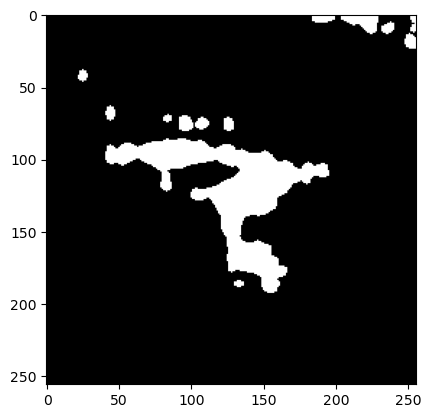

In [2]:
def create_image(image_path):
    # Load the terahertz image
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image_array = np.array(image)
    normalized_image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

    return normalized_image_array

def fill_tumor_regions(image):
    # Copy the image to prevent modification of the original
    filled_image = image.copy()
    
    # Find contours in the image
    contours, _ = cv2.findContours(filled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Iterate through each contour and fill the region
    for contour in contours:
        cv2.drawContours(filled_image, [contour], 0, 255, -1)
    
    return filled_image

def create_tumor_mask(image_path):
    # Load the terahertz image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256,256))
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color thresholds for tumor and non-tumor regions
    tumor_lower = np.array([0, 0, 0], dtype=np.uint8)  # Darker colors
    tumor_upper = np.array([20, 255, 255], dtype=np.uint8)  # Brighter colors than orange
    
    # Create the initial tumor mask based on the color thresholds
    tumor_mask = cv2.inRange(hsv_image, tumor_lower, tumor_upper)
    
    # Perform region filling to include missing parts in the tumor class
    tumor_mask_filled = fill_tumor_regions(tumor_mask)
    
    # Optional: Perform morphological operations to refine the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    tumor_mask_filled = cv2.morphologyEx(tumor_mask_filled, cv2.MORPH_OPEN, kernel)
    
    return tumor_mask_filled

def create_mask(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))
    hsv_image = image.convert("HSV")

    lower_tumor_color = np.array([0, 50, 50])  # Red (low hue value)
    upper_tumor_color = np.array([20, 255, 255])  # Orange (high hue value)

    mask = np.array(hsv_image) 
    mask = cv2.inRange(mask, lower_tumor_color, upper_tumor_color)

    mask = np.where(mask > 0, 1, 0)

    return mask

# Example usage
image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG\\B_bot_ImgAdj.jpg"
tumor_mask = create_tumor_mask(image_path)
a = np.where(tumor_mask > 0, 1, 0)
plt.imshow(a, cmap='gray')

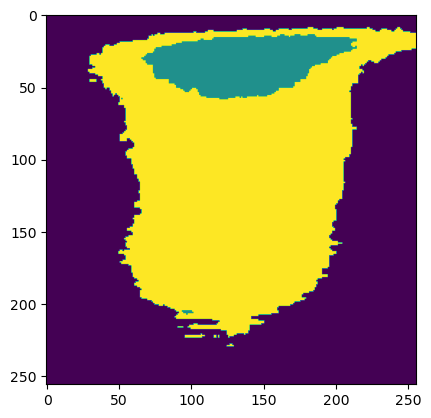

In [3]:
def create_tumor_mask_3(image_path):
    # Load the terahertz image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color thresholds for tumor, non-tumor, and third-class regions
    tumor_lower = np.array([0, 0, 0], dtype=np.uint8)  # Darker colors
    tumor_upper = np.array([20, 255, 255], dtype=np.uint8)  # Brighter colors than orange
    
    non_tumor_lower = np.array([20, 50, 50], dtype=np.uint8)  # Yellow, sky blue, and light green colors
    non_tumor_upper = np.array([90, 255, 255], dtype=np.uint8)
    
    # Create the initial tumor mask based on the color thresholds
    tumor_mask = cv2.inRange(hsv_image, tumor_lower, tumor_upper)
    
    # Create the mask for the non-tumor class
    non_tumor_mask = cv2.inRange(hsv_image, non_tumor_lower, non_tumor_upper)
    
    # Combine the tumor mask and non-tumor mask
    combined_mask = cv2.bitwise_or(tumor_mask, non_tumor_mask)
    
    # Perform region filling to include missing parts in the tumor class
    tumor_mask_filled = fill_tumor_regions(combined_mask)
    
    # Create the final mask with three classes (0, 1, 2)
    mask = np.zeros_like(tumor_mask_filled)
    mask[tumor_mask_filled == 255] = 1  # Tumor class
    mask[non_tumor_mask == 255] = 2  # Non-tumor class
    
    return mask


image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG\\T1_bot_550g_raw.jpg"
tumor_mask = create_tumor_mask_3(image_path)
plt.imshow(tumor_mask)

In [4]:
np.unique(tumor_mask)

array([0, 1, 2], dtype=uint8)

In [5]:
masks = []
images = []
image_folder = 'C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG'
image_files = os.listdir(image_folder)

for file_name in image_files:
    file_path = os.path.join(image_folder, file_name)
    image = create_image(file_path)
    mask = create_tumor_mask(file_path)
    a = np.where(mask > 0, 1, 0)
    masks.append(a)
    images.append(image)

In [6]:
a = create_mask(image_path)
b = create_tumor_mask(image_path)
a.shape

(256, 256)

In [7]:
masks = np.array(masks)

In [8]:
images = np.array(images)

In [9]:
print(images.shape)

(35, 256, 256, 3)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=10)
print("Train Shape : ", X_train.shape)
print("Test Shape : ", X_test.shape)

Train Shape :  (28, 256, 256, 3)
Test Shape :  (7, 256, 256, 3)


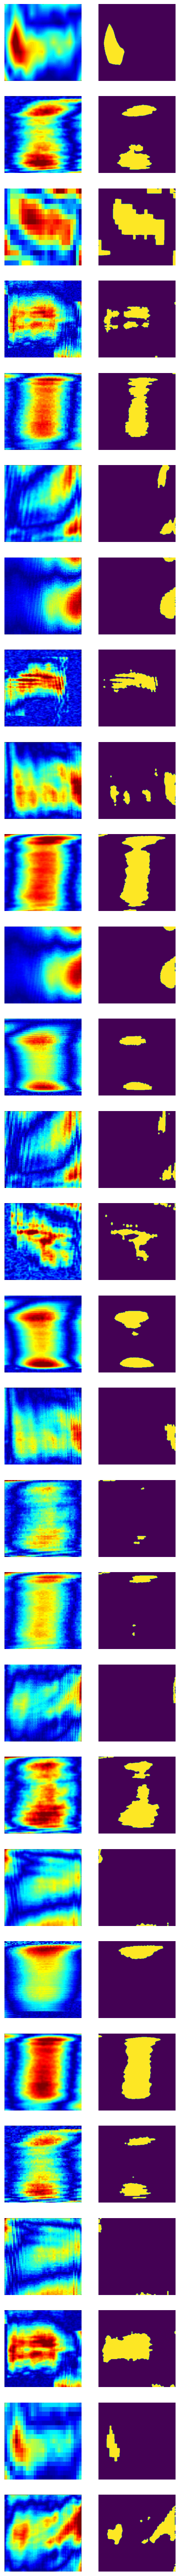

In [11]:
fig, ax = plt.subplots(X_train.shape[0], 2, figsize=(5, 75))
for i in range(X_train.shape[0]):
    mask_array = X_train[i]
    img_array = y_train[i]
    ax[i][0].set_axis_off()
    ax[i][1].set_axis_off()
    ax[i][1].imshow(img_array)
    ax[i][0].imshow(mask_array)

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights = "imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

model = build_vgg19_unet((256, 256, 3))
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 256)  590080      ['activation_2[0][0]']           
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 64, 64, 256)  0           ['batch_normalization_3[0][0]']  
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 12  131200     ['activation_3[0][0]']           
 spose)                         8)                                                                
          

In [14]:
epsilon = 1e-5
smooth = 1


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def iou(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    return (true_pos )/(true_pos + false_neg + false_pos)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [85]:
# # compling model and callbacks functions
# adam = tf.keras.optimizers.Adam(learning_rate = 0.025, epsilon = 0.1)
# model.compile(optimizer = adam,
#                   loss = focal_tversky,
#                   metrics = [iou])

# checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
#                                save_best_only=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               mode='min',
#                               patience=10,
#                               min_delta=0.0001,
#                               factor=0.2)

adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [iou]
                 )

checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [37]:
history = model.fit(X_train, y_train ,
                    epochs = 100,
                    validation_data = (X_test, y_test),
                    callbacks = [checkpointer, reduce_lr]
                 )

Epoch 1/100
1/1 [==============================] - 39s 39s/step - loss: 0.7459 - iou: 0.1289 - val_loss: 0.6793 - val_iou: 0.1752 - lr: 0.0500
Epoch 2/100
1/1 [==============================] - 32s 32s/step - loss: 0.7083 - iou: 0.1505 - val_loss: 0.6440 - val_iou: 0.1994 - lr: 0.0500
Epoch 3/100
1/1 [==============================] - 30s 30s/step - loss: 0.6856 - iou: 0.1647 - val_loss: 0.6106 - val_iou: 0.2239 - lr: 0.0500
Epoch 4/100
1/1 [==============================] - 31s 31s/step - loss: 0.6696 - iou: 0.1754 - val_loss: 0.5787 - val_iou: 0.2489 - lr: 0.0500
Epoch 5/100
1/1 [==============================] - 32s 32s/step - loss: 0.6563 - iou: 0.1846 - val_loss: 0.5481 - val_iou: 0.2743 - lr: 0.0500
Epoch 6/100
1/1 [==============================] - 31s 31s/step - loss: 0.6435 - iou: 0.1938 - val_loss: 0.5193 - val_iou: 0.2996 - lr: 0.0500
Epoch 7/100
1/1 [==============================] - 32s 32s/step - loss: 0.6300 - iou: 0.2037 - val_loss: 0.4927 - val_iou: 0.3241 - lr: 0.0500

Epoch 58/100
1/1 [==============================] - 30s 30s/step - loss: 0.0962 - iou: 0.8919 - val_loss: 0.1474 - val_iou: 0.8236 - lr: 0.0500
Epoch 59/100
1/1 [==============================] - 29s 29s/step - loss: 0.0948 - iou: 0.8941 - val_loss: 0.1431 - val_iou: 0.8324 - lr: 0.0500
Epoch 60/100
1/1 [==============================] - 31s 31s/step - loss: 0.0934 - iou: 0.8956 - val_loss: 0.1389 - val_iou: 0.8409 - lr: 0.0500
Epoch 61/100
1/1 [==============================] - 30s 30s/step - loss: 0.0922 - iou: 0.8966 - val_loss: 0.1360 - val_iou: 0.8474 - lr: 0.0500
Epoch 62/100
1/1 [==============================] - 30s 30s/step - loss: 0.0911 - iou: 0.8978 - val_loss: 0.1351 - val_iou: 0.8512 - lr: 0.0500
Epoch 63/100
1/1 [==============================] - 29s 29s/step - loss: 0.0900 - iou: 0.8994 - val_loss: 0.1361 - val_iou: 0.8526 - lr: 0.0500
Epoch 64/100
1/1 [==============================] - 29s 29s/step - loss: 0.0890 - iou: 0.9015 - val_loss: 0.1380 - val_iou: 0.8527 - lr:

In [38]:
tf.keras.models.save_model(model,'th100_model.h5')

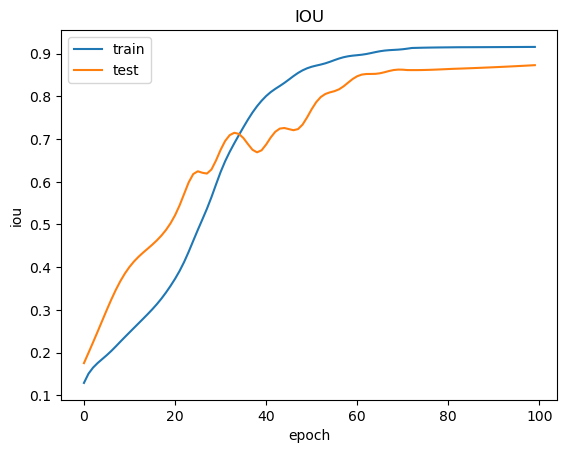

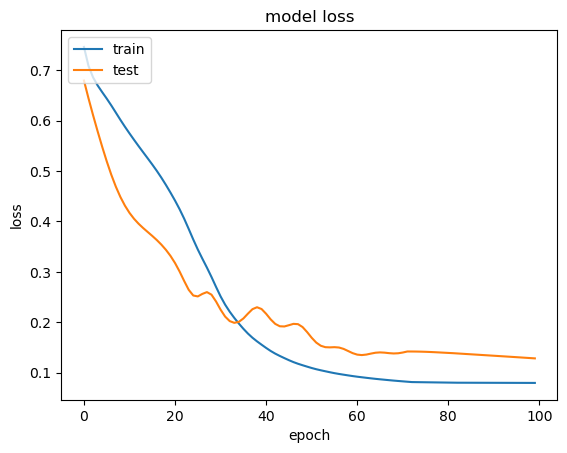

In [45]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IOU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
model = tf.keras.models.load_model('th100_model.h5',custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss, "iou" : iou})
pred = model.predict(X_test)
pred.shape

1/1 [==============================] - 3s 3s/step


(7, 256, 256, 1)

In [17]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.1285 - iou: 0.8732


[0.12853451073169708, 0.8732432126998901]

In [23]:
pred = (pred > 0.5)*1

In [24]:
pred = np.squeeze(pred)

In [25]:
pred.shape

(7, 256, 256)

In [26]:
def giveIoU(y_true, y_pred):
    m = tf.keras.metrics.MeanIoU(num_classes=3)
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [27]:
def giveAccuracy(y_true, y_pred):
    m = tf.keras.metrics.Accuracy()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [28]:
def giveIoUclasswise(y_true, y_pred):
    m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [29]:
classes = ["Background", "Tumor"]
def confusion_matrix(y_true, y_pred, class_label):
    return np.sum((y_true == class_label) & (y_pred == class_label))

def class_iou(y_true, y_pred, class_label):
    tp = confusion_matrix(y_true, y_pred, class_label)
    fp = np.sum((y_true != class_label) & (y_pred == class_label))
    fn = np.sum((y_true == class_label) & (y_pred != class_label))
    
    iou = tp / (tp + fp + fn + 1e-6) 
    return iou

def classwise_ious(y_true, y_pred, num_classes=2):
    class_ious = {}
    for class_label in range(num_classes):
        iou = class_iou(y_true, y_pred, class_label)
        class_ious[f'IoU {classes[class_label]}'] = iou
    return class_ious

In [30]:
def give_dice_coefficient(y_true, y_pred, num_classes=2, smooth=1e-6):
    # Ensure masks are integer type and within the range of [0, num_classes - 1]
    y_true = np.asarray(y_true, dtype=np.int64)
    y_pred = np.asarray(y_pred, dtype=np.int64)
    y_true = np.clip(y_true, 0, num_classes - 1)
    y_pred = np.clip(y_pred, 0, num_classes - 1)

    dice_per_class = []

    for i in range(num_classes):
        y_true_class = (y_true == i)
        y_pred_class = (y_pred == i)

        intersection = np.logical_and(y_true_class, y_pred_class).sum()
        union = y_true_class.sum() + y_pred_class.sum()

        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        dice_per_class.append(dice_score)

    # Calculate the average Dice coefficient across all classes
    average_dice_score = np.mean(dice_per_class)

    return average_dice_score


In [31]:
for i in range(pred.shape[0]):
    pred_mask_array = pred[i]
    mask_array = y_test[i]
    print("Image",i+1,": ")
    print("PixelWise Accuracy :", giveAccuracy(mask_array, pred_mask_array))
    print(classwise_ious(mask_array, pred_mask_array))
    print("Mean IoU :", giveIoU(mask_array, pred_mask_array))
    print("Dice coefficient :",give_dice_coefficient(mask_array, pred_mask_array))
    print()

Image 1 : 
PixelWise Accuracy : 0.99368286
{'IoU Background': 0.9934811362191617, 'IoU Tumor': 0.830466830126754}
Mean IoU : 0.91197395
Dice coefficient : 0.9520562299182095

Image 2 : 
PixelWise Accuracy : 0.99360657
{'IoU Background': 0.992717223141628, 'IoU Tumor': 0.9502493468356389}
Mean IoU : 0.9714833
Dice coefficient : 0.9854177049780413

Image 3 : 
PixelWise Accuracy : 0.99124146
{'IoU Background': 0.9893292682742911, 'IoU Tumor': 0.9534015261443902}
Mean IoU : 0.9713654
Dice coefficient : 0.9853904870915

Image 4 : 
PixelWise Accuracy : 0.9951477
{'IoU Background': 0.995100305060012, 'IoU Tumor': 0.6659663858550773}
Mean IoU : 0.8305334
Dice coefficient : 0.8985198612764342

Image 5 : 
PixelWise Accuracy : 0.996994
{'IoU Background': 0.9969587501389873, 'IoU Tumor': 0.7941483795254458}
Mean IoU : 0.8955536
Dice coefficient : 0.9418710282051579

Image 6 : 
PixelWise Accuracy : 0.98587036
{'IoU Background': 0.984439589968334, 'IoU Tumor': 0.8668009204737053}
Mean IoU : 0.925620

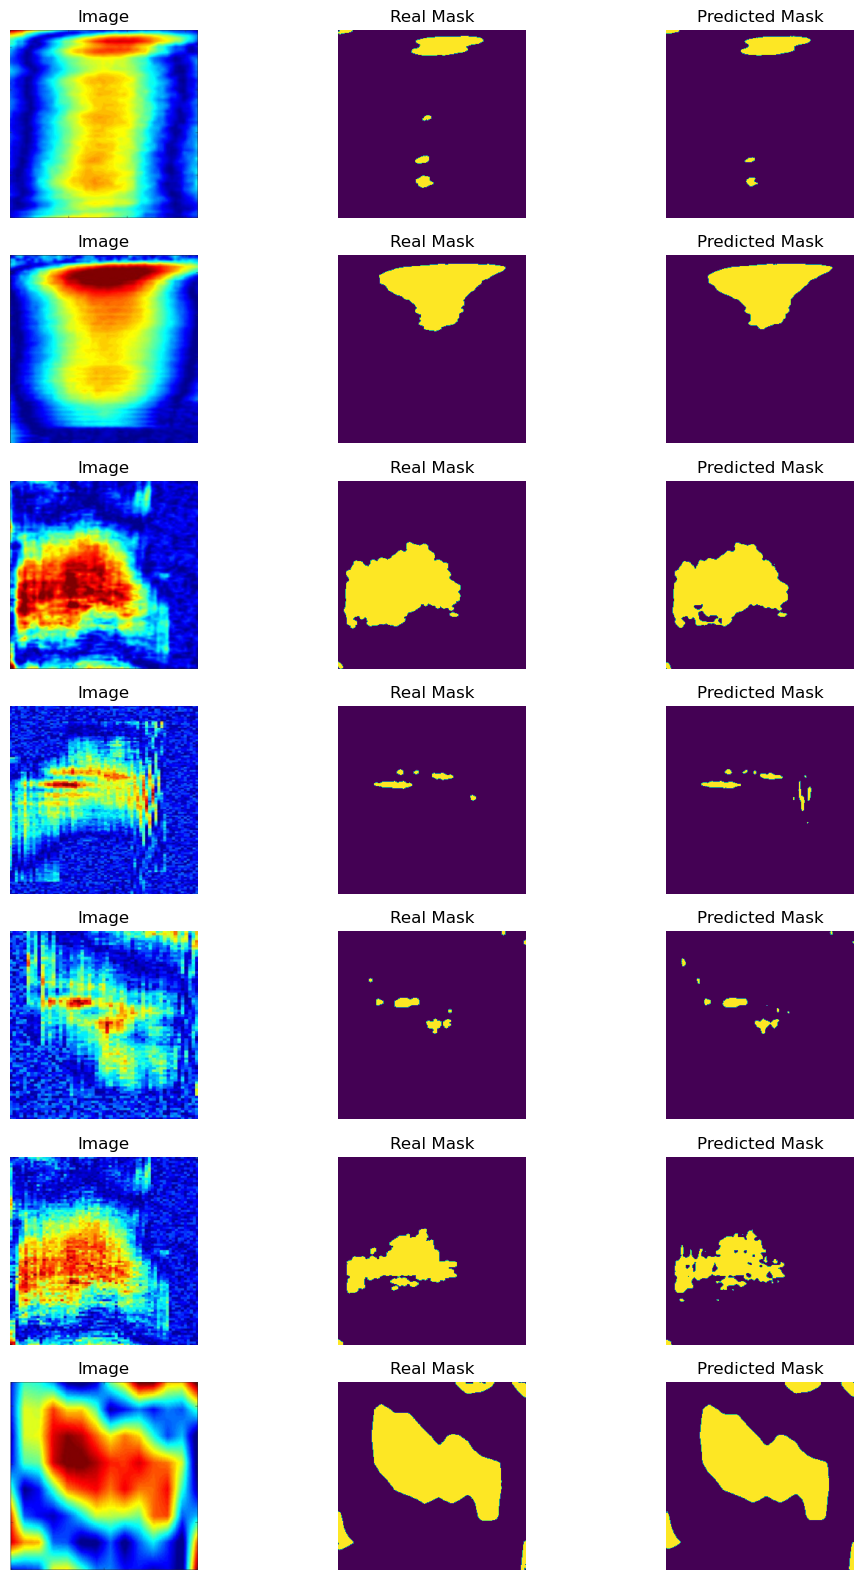

In [22]:
fig, ax = plt.subplots(7, 3, figsize=(12,20))
for i in range(pred.shape[0]):
    pred_mask_array = pred[i]
    img_array = X_test[i]
    mask_array = y_test[i]
    
    ax[i][0].imshow(img_array)
    ax[i][0].set_title("Image")
    ax[i][0].axis('off')
    ax[i][1].imshow(mask_array)
    ax[i][1].axis('off')
    ax[i][1].set_title("Real Mask")
    ax[i][2].axis('off')
    ax[i][2].imshow(pred_mask_array)
    ax[i][2].set_title("Predicted Mask")

# Working with 3 classes

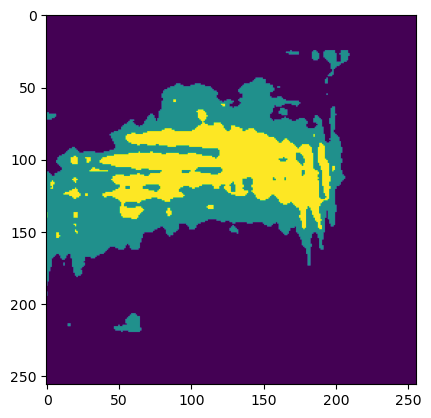

In [16]:
def create_tumor_mask_3(image_path):
    # Load the terahertz image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color thresholds for tumor, non-tumor, and third-class regions
    tumor_lower = np.array([0, 0, 0], dtype=np.uint8)  # Darker colors
    tumor_upper = np.array([20, 255, 255], dtype=np.uint8)  # Brighter colors than orange
    
    non_tumor_lower = np.array([20, 50, 50], dtype=np.uint8)  # Yellow, sky blue, and light green colors
    non_tumor_upper = np.array([90, 255, 255], dtype=np.uint8)
    
    # Create the initial tumor mask based on the color thresholds
    tumor_mask = cv2.inRange(hsv_image, tumor_lower, tumor_upper)
    
    # Create the mask for the non-tumor class
    non_tumor_mask = cv2.inRange(hsv_image, non_tumor_lower, non_tumor_upper)
    
    # Combine the tumor mask and non-tumor mask
    combined_mask = cv2.bitwise_or(tumor_mask, non_tumor_mask)
    
    # Perform region filling to include missing parts in the tumor class
    tumor_mask_filled = fill_tumor_regions(combined_mask)
    
    # Create the final mask with three classes (0, 1, 2)
    mask = np.zeros_like(tumor_mask_filled)
    mask[tumor_mask_filled == 255] = 2  # Tumor class
    mask[non_tumor_mask == 255] = 1  # Non-tumor class
    
    return mask


image_path = "C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG\\B_top_ImgAdj.jpg"
tumor_mask = create_tumor_mask_3(image_path)
plt.imshow(tumor_mask)

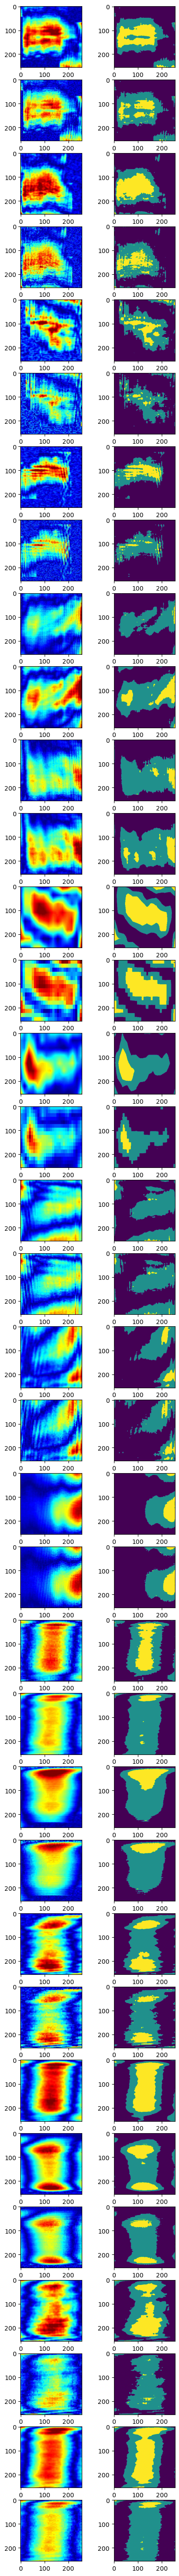

In [17]:
image_folder = 'C:\\Users\\apurv\\Desktop\\CSIR\\ALLIMG'
image_files = os.listdir(image_folder)
masks = []
images = []
fig, ax = plt.subplots(len(os.listdir(image_folder)), 2, figsize=(5, 75))
for i in range(len(os.listdir(image_folder))):
    fp = os.path.join(image_folder,image_files[i])
    mask = create_tumor_mask_3(fp)
    masks.append(mask)
    image = create_image(fp)
    images.append(image)
    ax[i][0].set_axis_off
    ax[i][0].imshow(image)
    ax[i][1].imshow(mask)
    

In [18]:
masks = np.array(masks)
images = np.array(images)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=10)
print("Train Shape : ", X_train.shape)
print("Test Shape : ", X_test.shape)

Train Shape :  (28, 256, 256, 3)
Test Shape :  (7, 256, 256, 3)


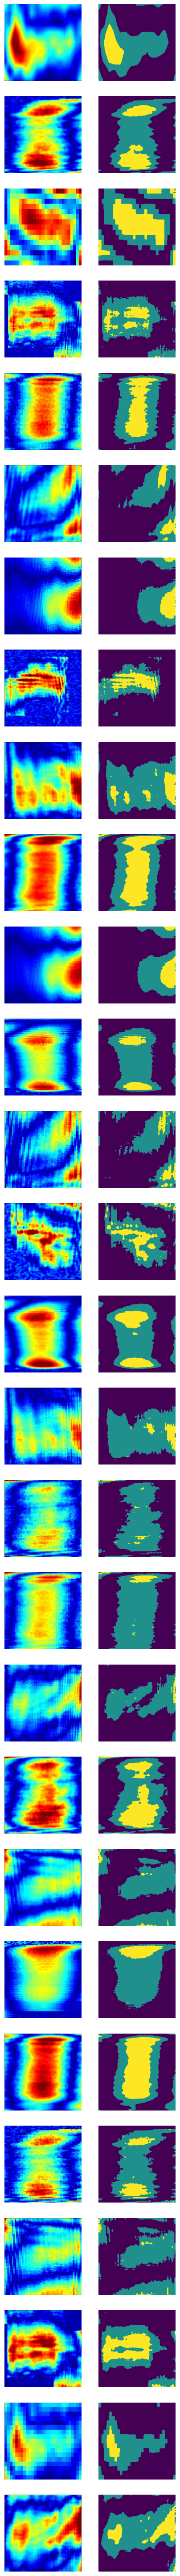

In [58]:
fig, ax = plt.subplots(X_train.shape[0], 2, figsize=(5, 75))
for i in range(X_train.shape[0]):
    mask_array = y_train[i]
    img_array = X_train[i]
    ax[i][0].set_axis_off()
    ax[i][1].set_axis_off()
    ax[i][0].imshow(img_array)
    ax[i][1].imshow(mask_array)

In [53]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape, num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

model = build_vgg19_unet(input_shape=(256, 256, 3), num_classes=3)
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

                                                                                                  
 conv2d_57 (Conv2D)             (None, 64, 64, 256)  590080      ['activation_50[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 64, 64, 256)  0           ['batch_normalization_51[0][0]'] 
                                                                                                  
 conv2d_transpose_26 (Conv2DTra  (None, 128, 128, 12  131200     ['activation_51[0][0]']          
 nspose)                        8)                                                                
          

In [38]:
# epsilon = 1e-5
# smooth = 1

# def tversky(y_true, y_pred):
#     y_true_pos = K.flatten(y_true)
#     y_pred_pos = K.flatten(y_pred)
#     true_pos = K.sum(y_true_pos * y_pred_pos)
#     false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
#     false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
#     alpha = 0.7
#     return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

# def iou(y_true, y_pred):
#     y_true_pos = K.flatten(y_true)
#     y_pred_pos = K.flatten(y_pred)
#     true_pos = K.sum(y_true_pos * y_pred_pos)
#     false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
#     false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
#     return true_pos / (true_pos + false_neg + false_pos)

# def focal_tversky(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     pt_1 = tversky(y_true, y_pred)
#     gamma = 0.75
#     return K.pow((1 - pt_1), gamma)

# def tversky_loss(y_true, y_pred):
#     return 1 - tversky(y_true, y_pred)

# import keras.backend as K

# def new_iou(y_true, y_pred):
#     y_true_pos = K.flatten(y_true)
#     y_pred_pos = K.flatten(y_pred)
    
#     intersection = K.sum(y_true_pos * y_pred_pos)
#     union = K.sum(K.maximum(y_true_pos, y_pred_pos))
#     iou_score = (intersection + K.epsilon()) / (union + K.epsilon())
    
#     return iou_score

In [60]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam,
                  loss = "sparse_categorical_crossentropy",
                  metrics = tf.keras.metrics.MeanIoU(3)
                 )

checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [55]:
history = model.fit(X_train, y_train ,
                    epochs = 100,
                    validation_data = (X_test, y_test),
                    callbacks = [checkpointer, reduce_lr]
                 )

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'confusion_matrix/stack_1' defined at (most recent call last):
    File "C:\Users\apurv\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\apurv\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\apurv\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\apurv\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\apurv\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\apurv\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\apurv\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\apurv\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\apurv\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\apurv\AppData\Local\Temp\ipykernel_17528\3904795118.py", line 1, in <module>
      history = model.fit(X_train, y_train ,
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\apurv\anaconda3\lib\site-packages\keras\metrics\metrics.py", line 2729, in update_state
      current_cm = tf.math.confusion_matrix(
Node: 'confusion_matrix/stack_1'
Shapes of all inputs must match: values[0].shape = [1835008] != values[1].shape = [5505024]
	 [[{{node confusion_matrix/stack_1}}]] [Op:__inference_train_function_36020]

In [ ]:
tf.keras.models.save_model(model,'th100_3_model.h5')